# Declare some variables


In [1]:
train_days=range(6+2)
test_days=[8,9]
basic_set_rows_in_dataset=range(40)
label_row_in_dataset=148
sequence_length = 100
learning_rate=0.0005
learning_rate_decay=0
batch_size=250
normalize=False
epoch=100

# Implement the model


In [2]:
from mypkg.model_implementations import CNN_RNN_2nd_try

Using TensorFlow backend.
/Users/liyeukhou/opt/anaconda3/envs/gradProj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/liyeukhou/opt/anaconda3/envs/gradProj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/liyeukhou/opt/anaconda3/envs/gradProj/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

# Preparation for Training and Testing






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 97, 1, 16)         2576      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 1, 16)         272       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 1, 32)         2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 1, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 45, 1, 32)         3104      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 1, 32)         0         
____________________

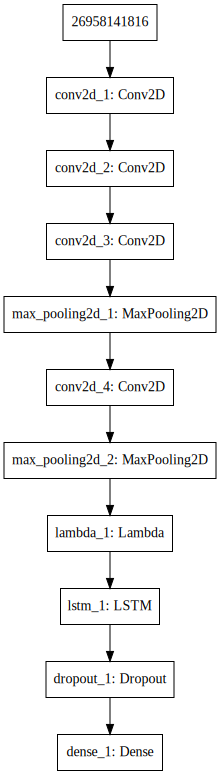

In [3]:
# Load the required packages
from keras.optimizers import Adam
from keras.engine.network import Network
from keras.utils.vis_utils import plot_model, model_to_dot
from IPython.core.display import SVG

# Build the model’s graph
second_model_of_CNN_RNN = CNN_RNN_2nd_try()

# Compile the model to Configure the learning process
second_model_of_CNN_RNN.compile(optimizer=Adam(lr=learning_rate, decay=learning_rate_decay), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the details of layers in a table with the sizes of its inputs/outputs
second_model_of_CNN_RNN.summary()

# Plot graph in a nice layout
plot_model(model=second_model_of_CNN_RNN, to_file='first_model_of_RNN.png')
SVG(data=model_to_dot(model=second_model_of_CNN_RNN).create(prog='dot', format='svg'))

# Generate .pkl files from dataset (Optional)

In [4]:
# Load the required packages
from numpy.lib.npyio import save

from mypkg.generate_pkl import convert_multiple_days_data_to_a_dataframe
train_dataframe=convert_multiple_days_data_to_a_dataframe(selected_train_or_test_days=train_days)
train_dataframe.to_pickle(path='train_dataframe.pkl')
test_dataframe=convert_multiple_days_data_to_a_dataframe(selected_train_or_test_days=test_days)
test_dataframe.to_pickle(path='test_dataframe.pkl')

from mypkg.generate_pkl import offset_for_each_stock_each_day
train_offset=offset_for_each_stock_each_day(selected_train_or_test_days=train_days)
save(file='train_offset',arr=train_offset)
test_offset=offset_for_each_stock_each_day(selected_train_or_test_days=test_days)
save(file='test_offset',arr=test_offset)

# Retrieve from saved .pkl files


In [4]:
# Load the required packages
from pandas.io.pickle import read_pickle
from keras.utils.np_utils import to_categorical
from numpy.lib.npyio import load


train_dataframe = read_pickle(path='train_dataframe.pkl')
test_dataframe = read_pickle(path='test_dataframe.pkl')
train_offset = load(file='train_offset.npy')
# print(type(train_offset))
# print(train_offset.shape)
# print(train_offset)
test_offset = load(file='test_offset.npy')

# Load the dataset


In [5]:
X_train = train_dataframe.iloc[:, basic_set_rows_in_dataset].values  # 提取前40列所有行并转换为numpy形式
Y_train = to_categorical(y=train_dataframe.iloc[:, label_row_in_dataset].values - 1)  # 将真实值转化为0-1向量,向前预测5个period, 用不用-1?
X_test = test_dataframe.iloc[:, basic_set_rows_in_dataset].values
Y_test = to_categorical(y=test_dataframe.iloc[:, label_row_in_dataset].values - 1)

from mypkg.batch_generators import batch_generator_for_CNN

# Training


In [6]:
# Load the required packages
from keras.callbacks import TensorBoard, ModelCheckpoint

from mypkg.batch_counter import batches_amount_per_epoch

# Train the model
a_history_object = second_model_of_CNN_RNN.fit_generator(
    generator=batch_generator_for_CNN(normalize=normalize, X_dataset=X_train,Y_dataset=Y_train,offset=train_offset,sequence_length=sequence_length,batch_size=batch_size),
    validation_data=batch_generator_for_CNN(normalize=normalize, X_dataset=X_test,Y_dataset=Y_test,offset=test_offset,sequence_length=sequence_length,batch_size=batch_size),
    steps_per_epoch=batches_amount_per_epoch(offset=train_offset,sequence_length=sequence_length,batch_size=batch_size),
    validation_steps=batches_amount_per_epoch(offset=test_offset,sequence_length=sequence_length,batch_size=batch_size),
    epochs=epoch,
    verbose=2,
    callbacks=[TensorBoard(write_images=True),
               ModelCheckpoint(filepath='E:\liyeukhou\graduation_project\saved_models\weights.{epoch:02d}-{val_loss:.2f}.h5', monitor='loss',save_best_only=True)])

Epoch 1/100
 - 55s - loss: 1.1365 - acc: 0.3895 - val_loss: 1.1033 - val_acc: 0.3441
Epoch 2/100
 - 48s - loss: 1.0700 - acc: 0.3928 - val_loss: 1.0990 - val_acc: 0.3507
Epoch 3/100
 - 48s - loss: 1.0698 - acc: 0.4008 - val_loss: 1.1087 - val_acc: 0.3073
Epoch 4/100
 - 48s - loss: 1.0677 - acc: 0.4005 - val_loss: 1.1018 - val_acc: 0.3614
Epoch 5/100
 - 48s - loss: 1.0646 - acc: 0.4015 - val_loss: 1.1049 - val_acc: 0.3712
Epoch 6/100
 - 48s - loss: 1.0601 - acc: 0.4031 - val_loss: 1.1009 - val_acc: 0.3635
Epoch 7/100
 - 47s - loss: 1.0564 - acc: 0.4032 - val_loss: 1.1077 - val_acc: 0.3182
Epoch 8/100
 - 47s - loss: 1.0618 - acc: 0.3999 - val_loss: 1.0963 - val_acc: 0.3687
Epoch 9/100
 - 48s - loss: 1.0516 - acc: 0.4062 - val_loss: 1.0817 - val_acc: 0.3884
Epoch 10/100
 - 47s - loss: 1.0313 - acc: 0.4194 - val_loss: 1.0830 - val_acc: 0.3983
Epoch 11/100
 - 47s - loss: 1.0032 - acc: 0.4539 - val_loss: 1.0265 - val_acc: 0.4609
Epoch 12/100
 - 48s - loss: 0.9771 - acc: 0.4794 - val_loss: 0.

# Make sure my model is learning by monitoring the tendency of loss

Text(0, 0.5, 'Cost')

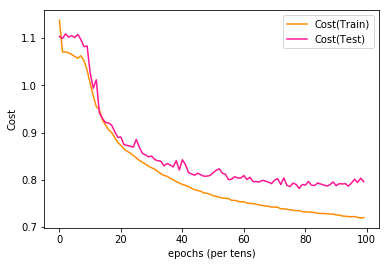

In [7]:
# Load the required packages
import matplotlib.pyplot as pyplot
%matplotlib inline

pyplot.figure()
pyplot.plot(a_history_object.history['loss'], color='darkorange', ls='-', label='Cost(Train)')
pyplot.plot(a_history_object.history['val_loss'], color='deeppink', ls='-', label='Cost(Test)')
pyplot.legend()
pyplot.xlabel(xlabel='epochs (per tens)')
pyplot.ylabel(ylabel='Cost')

# Testing


In [8]:
# Load the required packages
from keras.engine.training import Model
from numpy.core.multiarray import concatenate
from numpy.core._multiarray_umath import ndarray

train_data=batch_generator_for_CNN(normalize=normalize, X_dataset=X_train,Y_dataset=Y_train,offset=train_offset,sequence_length=sequence_length,batch_size=batch_size)
validation_data=batch_generator_for_CNN(normalize=normalize, X_dataset=X_test,Y_dataset=Y_test,offset=test_offset,sequence_length=sequence_length,batch_size=batch_size)
steps_per_epoch=batches_amount_per_epoch(offset=train_offset,sequence_length=sequence_length,batch_size=batch_size)
validation_steps=batches_amount_per_epoch(offset=test_offset,sequence_length=sequence_length,batch_size=batch_size)

Y_train_true_predictions=[]
Y_hat_train_predictions=[]
Y_test_true_predictions=[]
Y_hat_test_predictions=[]

for each_step in range(int(x=steps_per_epoch)):
    temp=next(train_data)  # 长为2的tuple
    Y_train_true_predictions.append(temp[1]) # for几次长度就是几，就是直接把temp[1]这个真实值ndarray附到list里去了
    Y_hat_train_predictions.append(second_model_of_CNN_RNN.predict(x=temp[0]))   # 同上，但是附的是拿[0]计算出来的预测值

for each_step in range(int(x=validation_steps)):
    temp=next(validation_data)
    Y_test_true_predictions.append(temp[1])
    Y_hat_test_predictions.append(second_model_of_CNN_RNN.predict(x=temp[0]))

Y_train_true_predictions=concatenate(Y_train_true_predictions).reshape(-1,3)  # list变ndarray
Y_hat_train_predictions=concatenate(Y_hat_train_predictions).reshape(-1,3)    # list变ndarray
Y_test_true_predictions=concatenate(Y_test_true_predictions).reshape(-1,3)
Y_hat_test_predictions=concatenate(Y_hat_test_predictions).reshape(-1,3)

# Assessment


In [9]:
# Load the required packages
from numpy.core.fromnumeric import argmax
from sklearn.metrics.classification import classification_report,cohen_kappa_score

print('-----How well have we done on training data-----')
y=argmax(Y_train_true_predictions,axis=1)
y_hat=argmax(Y_hat_train_predictions,axis=1)
print(classification_report(y_true=y,y_pred=y_hat))
Cohens_kappa_coefficient=cohen_kappa_score(y1=y,y2=y_hat)
print(f'Cohen Kappa Score = {Cohens_kappa_coefficient}')

print()

print('-----How well have we done on test data-----')
y=argmax(Y_test_true_predictions,axis=1)
y_hat=argmax(Y_hat_test_predictions,axis=1)
print(classification_report(y_true=y,y_pred=y_hat))
Cohens_kappa_coefficient=cohen_kappa_score(y1=y,y2=y_hat)
print(f'Cohen Kappa Score = {Cohens_kappa_coefficient}')

-----How well have we done on training data-----
              precision    recall  f1-score   support

           0       0.71      0.65      0.68    120347
           1       0.70      0.68      0.69     69882
           2       0.66      0.74      0.70    116039

   micro avg       0.69      0.69      0.69    306268
   macro avg       0.69      0.69      0.69    306268
weighted avg       0.69      0.69      0.69    306268

Cohen Kappa Score = 0.5194826700861125

-----How well have we done on test data-----
              precision    recall  f1-score   support

           0       0.64      0.62      0.63     29147
           1       0.74      0.65      0.69     26310
           2       0.60      0.70      0.65     27662

   micro avg       0.65      0.65      0.65     83119
   macro avg       0.66      0.65      0.66     83119
weighted avg       0.66      0.65      0.65     83119

Cohen Kappa Score = 0.4803702819784149


# Predictor Visualisation

In [10]:
# Load the required packages
from numpy.lib.function_base import average
from matplotlib.pyplot import title
import matplotlib.pyplot as pyplot
%matplotlib inline

up_movement_contributor=[]
down_movement_contributor=[]

train_data=batch_generator_for_CNN(normalize=normalize, X_dataset=X_train,Y_dataset=Y_train,offset=train_offset,sequence_length=sequence_length,batch_size=batch_size)

for each_batch in range(int(x=steps_per_epoch)):
    temp=next(train_data)[0]    # ???
    # print(type(next(train_data)[0]))
    # print(next(train_data)[0].shape)
    # print(next(train_data)[0])
    y_hat_train=second_model_of_CNN_RNN.predict(x=temp)
    # print(y_hat_train)
    # print()
    up_movement_contributor.append(temp[argmax(a=y_hat_train[:,0])])
    # print(argmax(a=y_hat_train[:,0]))
    # print()
    down_movement_contributor.append(temp[argmax(a=y_hat_train[:,2])])
    # print(argmax(a=y_hat_train[:,2]))
    # print()

# print(type(up_movement_contributor))
# print(len(up_movement_contributor))
# print(up_movement_contributor)

In [11]:
up_movement_contributor_avg=average(a=up_movement_contributor,axis=0)
# print(type(up_movement_contributor_avg))
# print(up_movement_contributor_avg.shape)
# print(up_movement_contributor_avg)
down_movement_contributor_avg=average(a=down_movement_contributor,axis=0)

Text(0.5, 1.0, 'volume at bid side')

<Figure size 432x288 with 0 Axes>

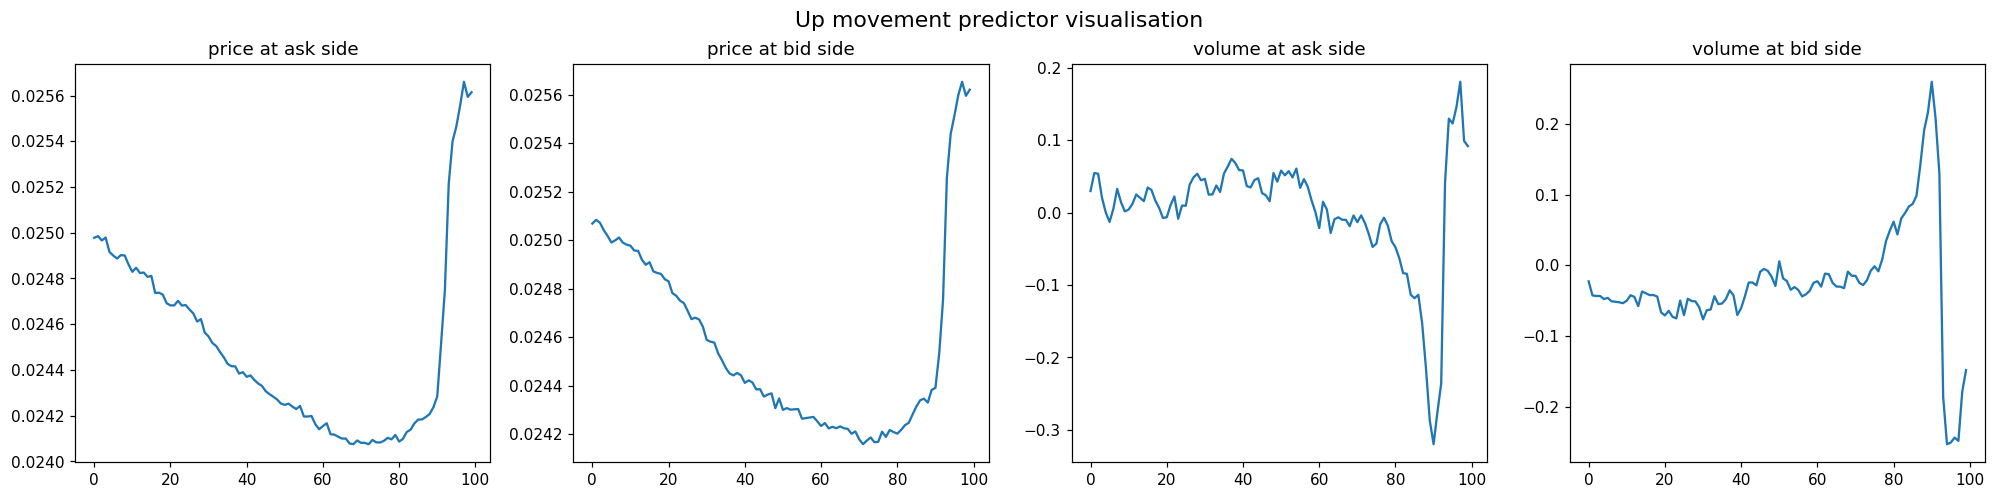

In [12]:
pyplot.tight_layout()

pyplot.figure(figsize=(22.4,4.8),dpi=110)
pyplot.suptitle(t="Up movement predictor visualisation",fontsize='x-large')

pyplot.subplot(1,4,1)
pyplot.plot(up_movement_contributor_avg[:,0,0], ls='-')
title(label='price at ask side')

pyplot.subplot(1,4,2)
pyplot.plot(up_movement_contributor_avg[:,2,0], ls='-')
title(label='price at bid side')

pyplot.subplot(1,4,3)
pyplot.plot(up_movement_contributor_avg[:,1,0], ls='-')
title(label='volume at ask side')

pyplot.subplot(1,4,4)
pyplot.plot(up_movement_contributor_avg[:,3,0], ls='-')
title(label='volume at bid side')

Text(0.5, 1.0, 'volume at bid side')

<Figure size 432x288 with 0 Axes>

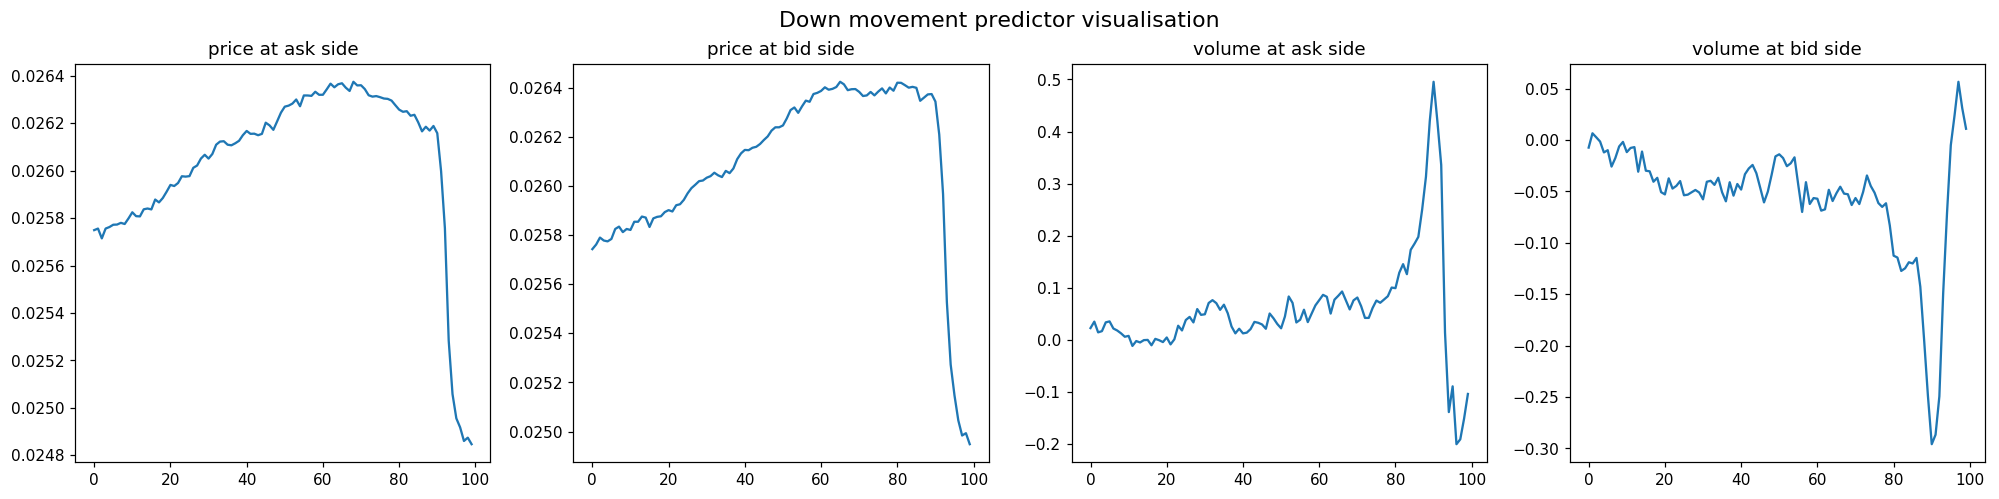

In [13]:
pyplot.tight_layout()

pyplot.figure(figsize=(22.4,4.8),dpi=110)
pyplot.suptitle(t="Down movement predictor visualisation",fontsize='x-large')

pyplot.subplot(1,4,1)
pyplot.plot(down_movement_contributor_avg[:,0,0], ls='-')
title(label='price at ask side')

pyplot.subplot(1,4,2)
pyplot.plot(down_movement_contributor_avg[:,2,0], ls='-')
title(label='price at bid side')

pyplot.subplot(1,4,3)
pyplot.plot(down_movement_contributor_avg[:,1,0], ls='-')
title(label='volume at ask side')

pyplot.subplot(1,4,4)
pyplot.plot(down_movement_contributor_avg[:,3,0], ls='-')
title(label='volume at bid side')

# Visulising what my CNN filters (at intermediate layers) were learning to specialize using Gradient Ascent

In [14]:
# Load the required packages
from keras.backend.tensorflow_backend import mean,gradients,function
from numpy.random.mtrand import random
import matplotlib.pyplot as pyplot
%matplotlib inline

from mypkg.my_normalize_gradients import normalize

In [15]:
layers_dict=dict([(layer.name,layer)for layer in second_model_of_CNN_RNN.layers])
selected_layer='conv2d_4'
layer_output=layers_dict[selected_layer].output # activation_4的output
# print('layer_output\'s type: '+str(type(layer_output))) # 是个Tensor
# print('layer_output = '+str(layer_output))

kept_filters=[]
for filter_index in range(32):
    print(f'Processing filter {filter_index}')
    normalized_grads=normalize(x=gradients(loss=mean(x=layer_output[:,:,:,filter_index]),variables=second_model_of_CNN_RNN.input)[0])# Loss定义为这一层给出的score，这个损失函数将用于最大化指定滤波器的激活值，以该函数为优化目标优化后，我们希望可以看到使得这个滤波器激活的究竟是什么。
    forward_and_backward_function=function(inputs=[second_model_of_CNN_RNN.input],outputs=[mean(x=layer_output[:,:,:,filter_index]),normalized_grads])    # forward-prop x，计算Loss和∂L/∂x

    input_signal=random(size=(1,100,40,1))  # channels_last
    alpha=1
    # 对某个滤波器的激活值进行梯度上升，将当前数据朝着梯度的方向去"增强"
    for i in range(1000):
        loss,grads=forward_and_backward_function(inputs=[input_signal])  # 计算L和∂L/∂x以找到使L最大的那个x
        input_signal=input_signal+alpha*grads   # 更新x
        if loss<=0.:
            break
    print(f'Final loss value from filter no.{filter_index} = {loss}')
    if loss>0:
        kept_filters.append((input_signal[0],loss))
print('Total number of filters that possess positive loss value: ' + str(len(kept_filters)))

Processing filter 0
Final loss value from filter no.0 = 0.0
Processing filter 1
Final loss value from filter no.1 = 41614.9375
Processing filter 2
Final loss value from filter no.2 = 0.0
Processing filter 3
Final loss value from filter no.3 = 26543.5859375
Processing filter 4
Final loss value from filter no.4 = 105389.921875
Processing filter 5
Final loss value from filter no.5 = 83761.78125
Processing filter 6
Final loss value from filter no.6 = 0.0
Processing filter 7
Final loss value from filter no.7 = 105046.3125
Processing filter 8
Final loss value from filter no.8 = 0.0
Processing filter 9
Final loss value from filter no.9 = 0.0
Processing filter 10
Final loss value from filter no.10 = 59060.6171875
Processing filter 11
Final loss value from filter no.11 = 77511.515625
Processing filter 12
Final loss value from filter no.12 = 26140.84765625
Processing filter 13
Final loss value from filter no.13 = 38700.390625
Processing filter 14
Final loss value from filter no.14 = 68491.953125

<Figure size 432x288 with 0 Axes>

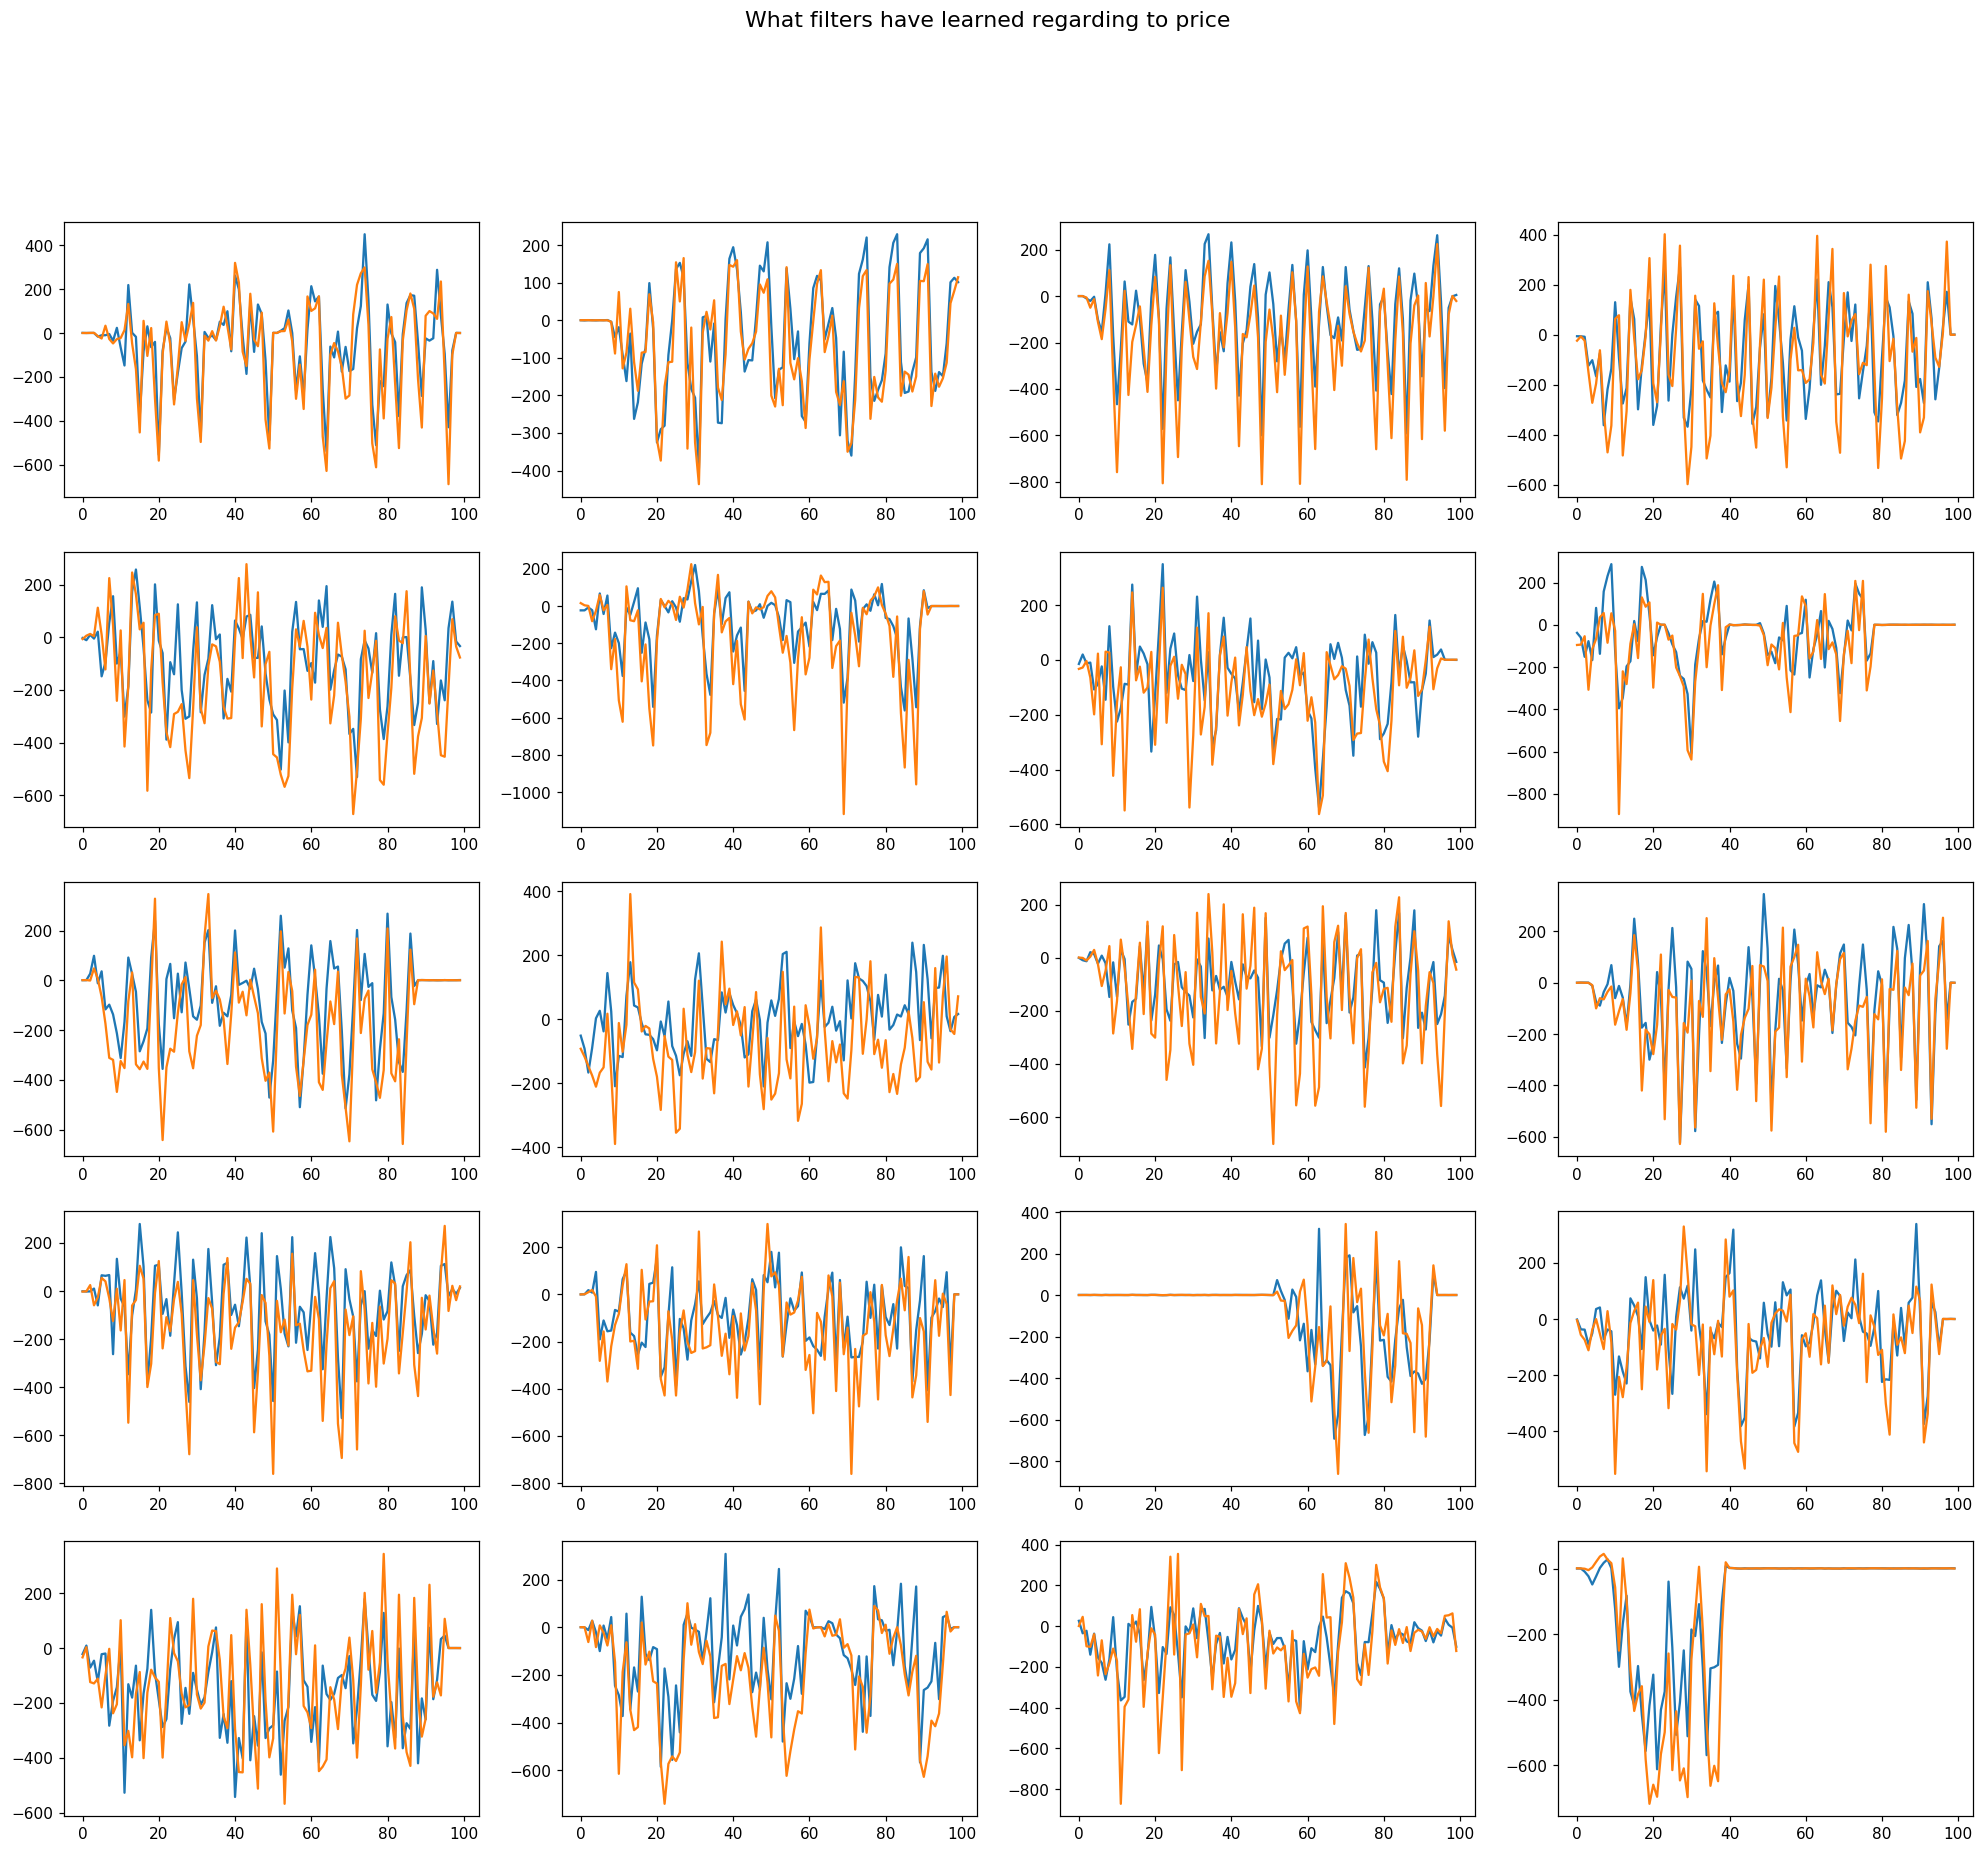

In [16]:
pyplot.tight_layout()
pyplot.figure(figsize=(22.4,19.2),dpi=110)
pyplot.suptitle(t="What filters have learned regarding to price",fontsize='x-large')
for index, each_content in enumerate(iterable=kept_filters):
    one_msg=each_content[0][:,:,0]  # [0]:看input_signal[0](3D), one_msg:(100,40)
    pyplot.subplot(5,4,index+1)
    pyplot.plot(one_msg[:,[0,2]])  # ask/bid price at level 0

<Figure size 432x288 with 0 Axes>

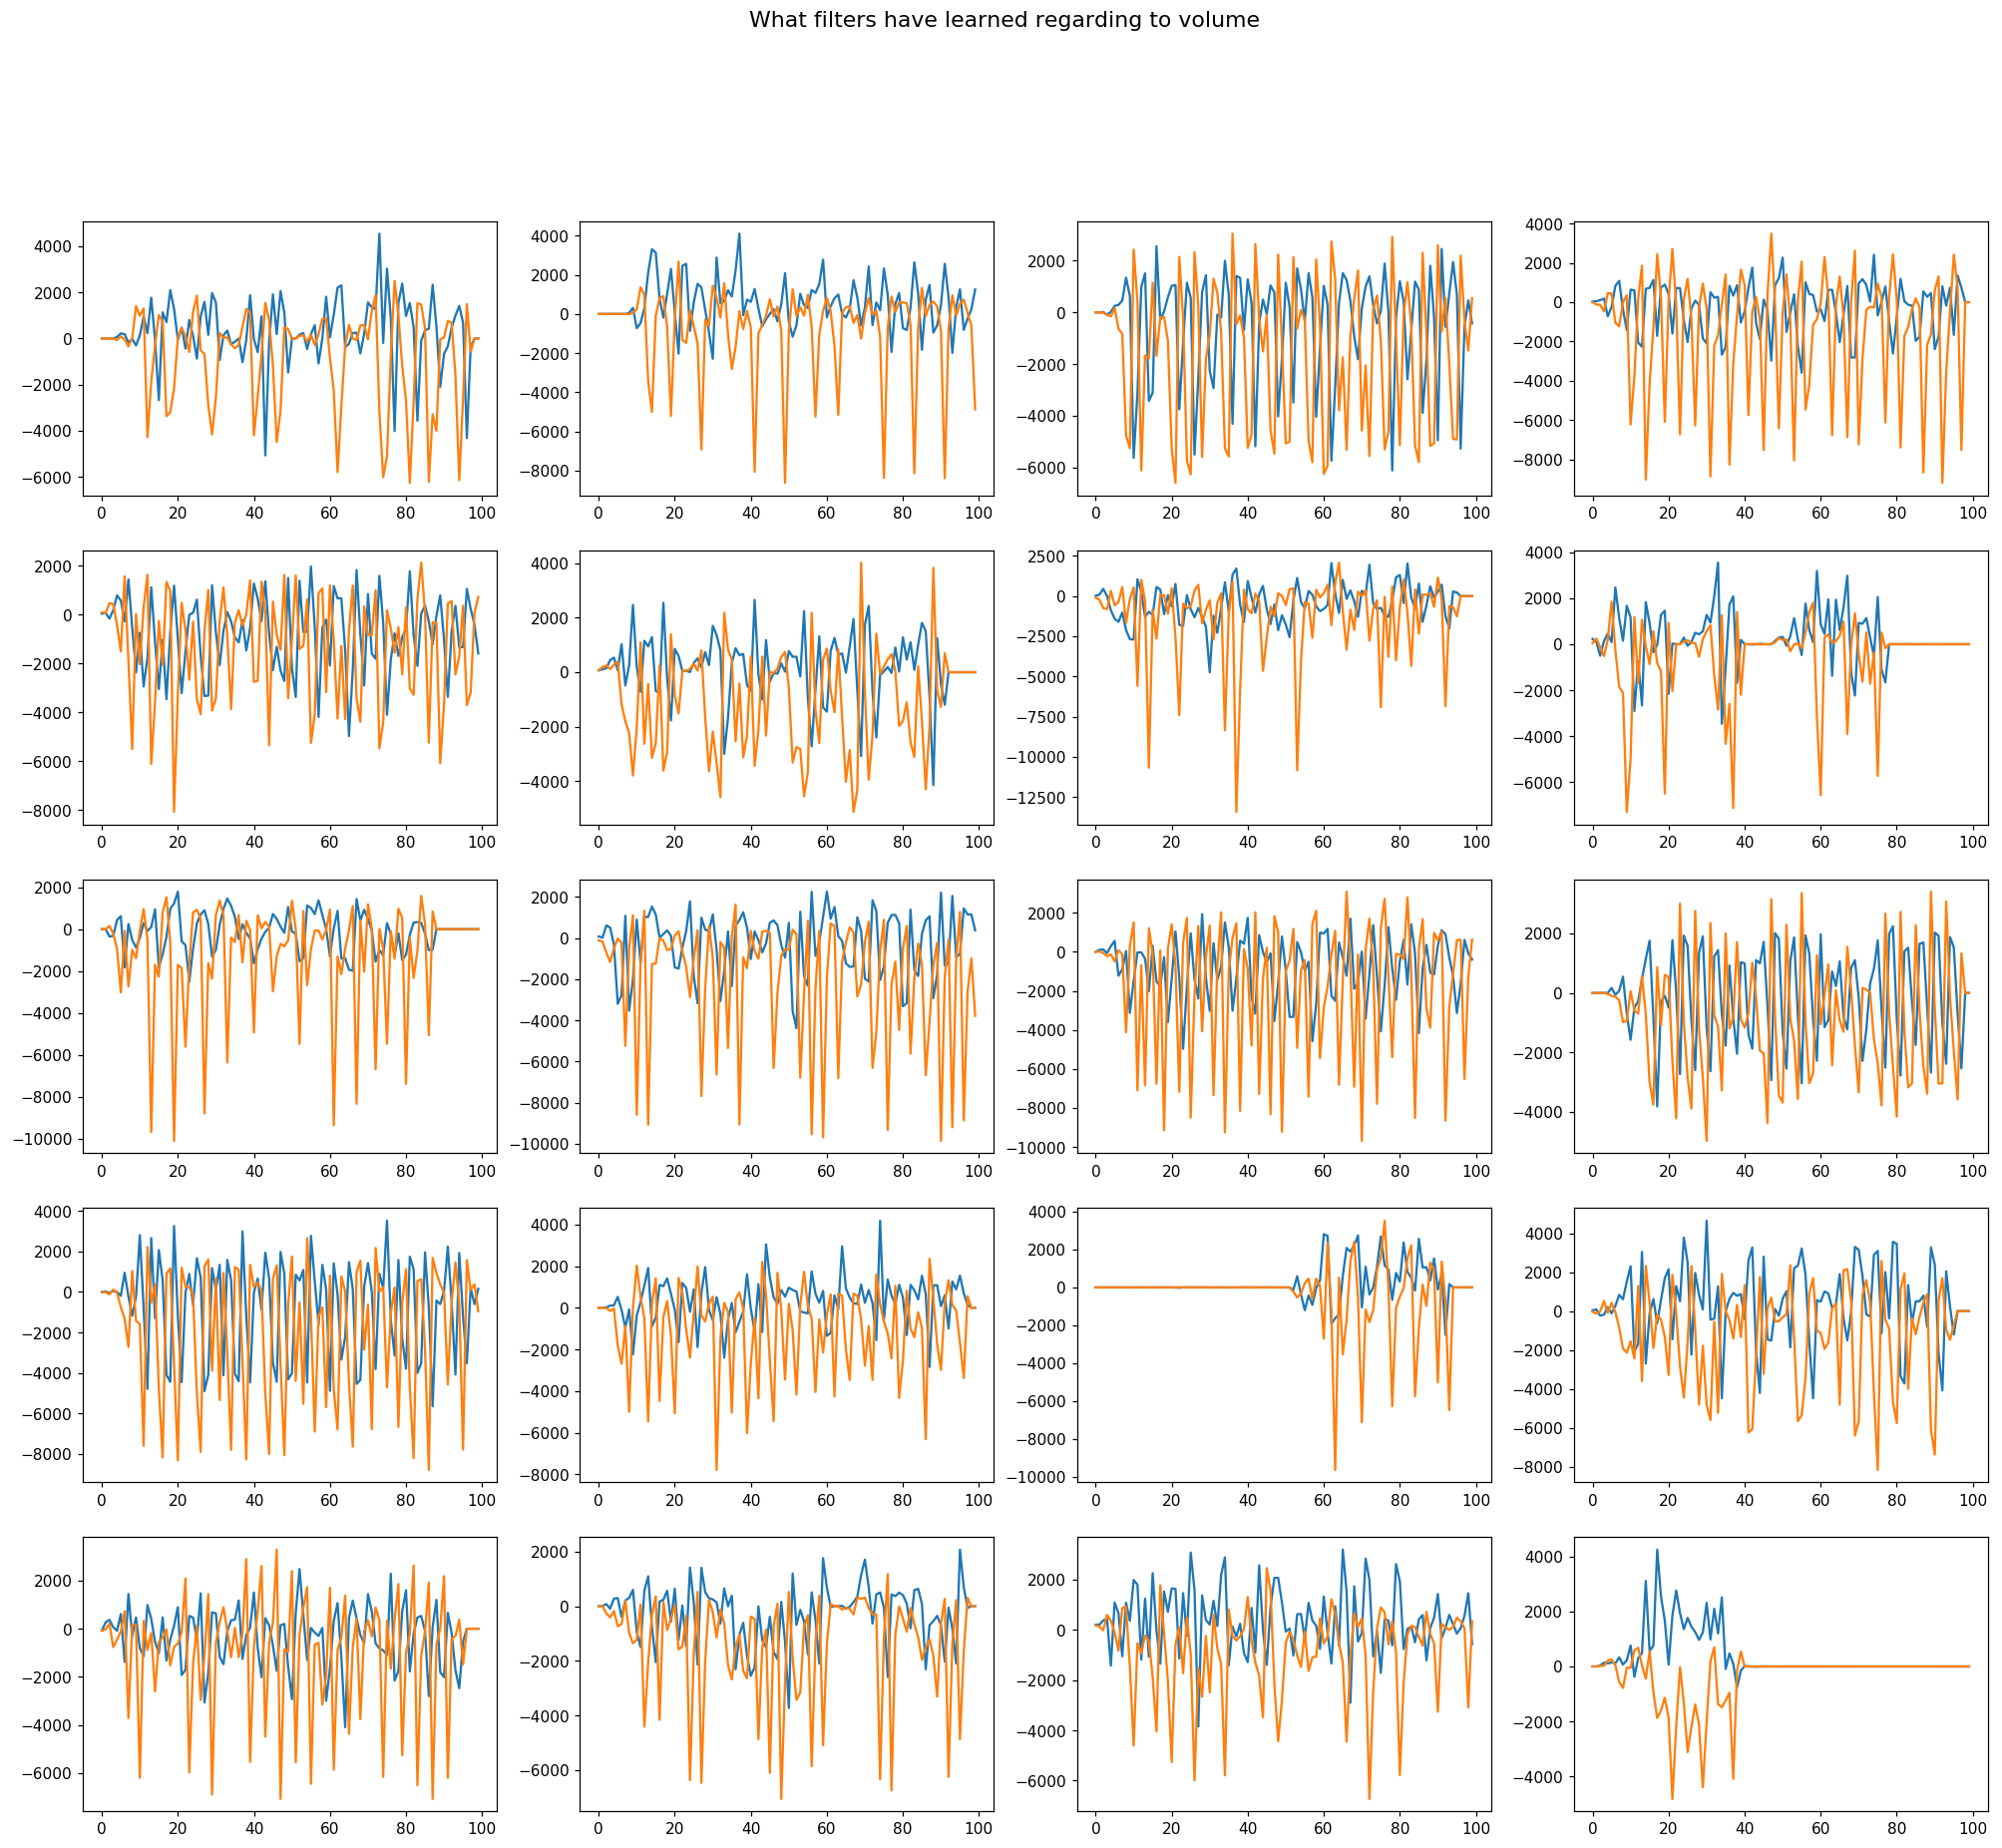

In [17]:
pyplot.tight_layout()
pyplot.figure(figsize=(22.4,19.2),dpi=110)
pyplot.suptitle(t="What filters have learned regarding to volume",fontsize='x-large')
for index, each_content in enumerate(iterable=kept_filters):
    one_msg=each_content[0][:,:,0]  # [0]:看input_signal[0](3D), one_msg:(100,40)
    pyplot.subplot(5,4,index+1)
    pyplot.plot(one_msg[:,[1,3]])  # ask/bid volume at level 0

In [18]:
selected_layer='dense_1'
layer_output=layers_dict[selected_layer].output

magic_list=[]
for each_category in range(3):
    # print('grads = ' + str(grads))
    normalized_grads=normalize(x=gradients(loss=layer_output[:,each_category],variables=second_model_of_CNN_RNN.input)[0])
    forward_and_backward_function=function(inputs=[second_model_of_CNN_RNN.input],outputs=[mean(x=layer_output[:,each_category]),normalized_grads])
    # Computing Gradient Ascent
    input_signal=random(size=(1,100,40,1))
    alpha=1
    for i in range(1000):
        loss,grads=forward_and_backward_function(inputs=[input_signal])  # 计算L和∂L/∂x以找到使L最大的那个x
        input_signal=input_signal+alpha*grads   # 更新x
    print(f'For label {each_category}, Final loss value = {loss}')
    magic_list.append((input_signal[0],loss))

For label 0, Final loss value = 1.0
For label 1, Final loss value = 0.0
For label 2, Final loss value = 1.0


In [19]:
label_0_input_array=magic_list[0][0]    # shape=(100, 40, 1)
label_2_input_array=magic_list[2][0]

Text(0.5, 1.0, 'Level 1 ask/bid price associated with down movement prediction')

<Figure size 432x288 with 0 Axes>

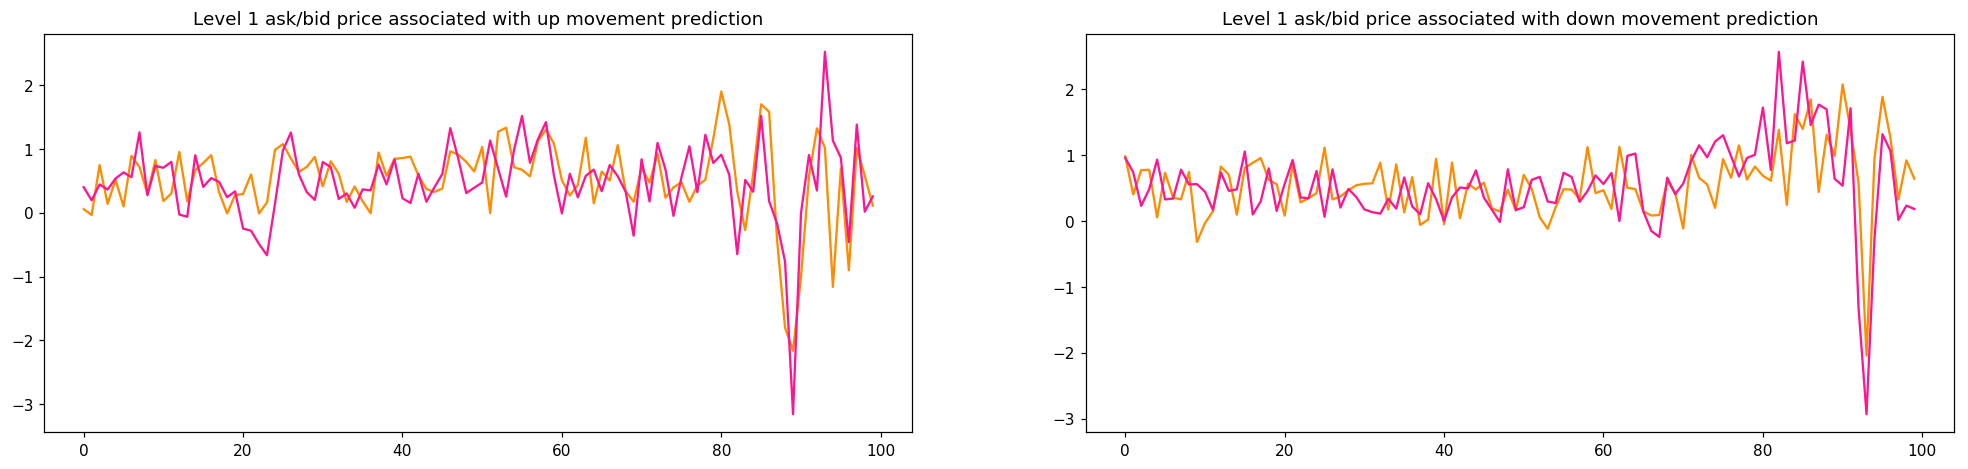

In [20]:
pyplot.tight_layout()

pyplot.figure(figsize=(22.4,4.8),dpi=110)

pyplot.subplot(1,2,1)
pyplot.plot(label_0_input_array[:,0,0], color='darkorange', ls='-', label='Ask price at level 1')
pyplot.plot(label_0_input_array[:,0+2,0], color='deeppink', ls='-', label='Bid price at level 1')
title(label='Level 1 ask/bid price associated with up movement prediction')

pyplot.subplot(1,2,2)
pyplot.plot(label_2_input_array[:,0,0], color='darkorange', ls='-', label='Ask price at level 1')
pyplot.plot(label_2_input_array[:,0+2,0], color='deeppink', ls='-', label='Bid price at level 1')
title(label='Level 1 ask/bid price associated with down movement prediction')